In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykrx import stock
import datetime
import time

# 주어진 주식 코드와 날짜 범위에 대한 시장 데이터를 가져오는 함수
def get_market_data(start_date, end_date, stock_code):
    df = stock.get_market_ohlcv(start_date, end_date, stock_code)
    return df






# 종목 수익률 상관관계

In [33]:
# 관심 있는 주식 코드 목록
stock_codes = [
    '010420', '016920', '021240', '032750', '037400', '037710',
    '039740', '045060', '075130', '084010','088790', '093920', '136540',
    '225590', '308620', '317400', '334690', '364990', '371460',
    '227540', 
] # Up to 20 stock codes

# 각 주식에 대한 데이터를 저장할 딕셔너리
stock_data = {}

# 각 주식에 대한 시장 데이터를 가져와 딕셔너리에 저장
for code in stock_codes:
    df = get_market_data("20160102", "20231220", code)
    df.index = pd.to_datetime(df.index)
    stock_data[code] = df

# # 데이터 확인
# for code, df in stock_data.items():
#     print(f"{code} 데이터 샘플:")
#     print(df.head())

In [34]:
# 수익률과 상관관계를 계산
returns = pd.DataFrame(index=stock_data[stock_codes[0]].index)
for code in stock_codes:
    df = stock_data[code]
    for period, label in zip([1, 5, 20, 252], ['daily', 'weekly', 'monthly', 'yearly']):
        returns[f'{code}_{label}_return'] = df['종가'].pct_change(periods=period)

# pct_change 계산으로 인해 발생한 NaN 값을 제거
returns.dropna(inplace=True)




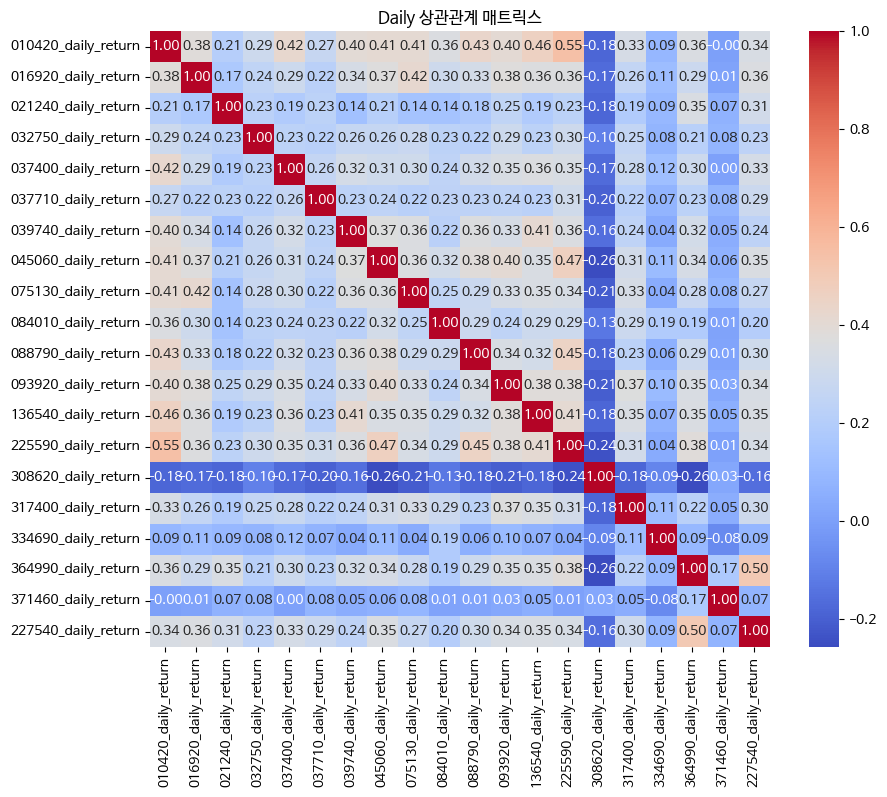

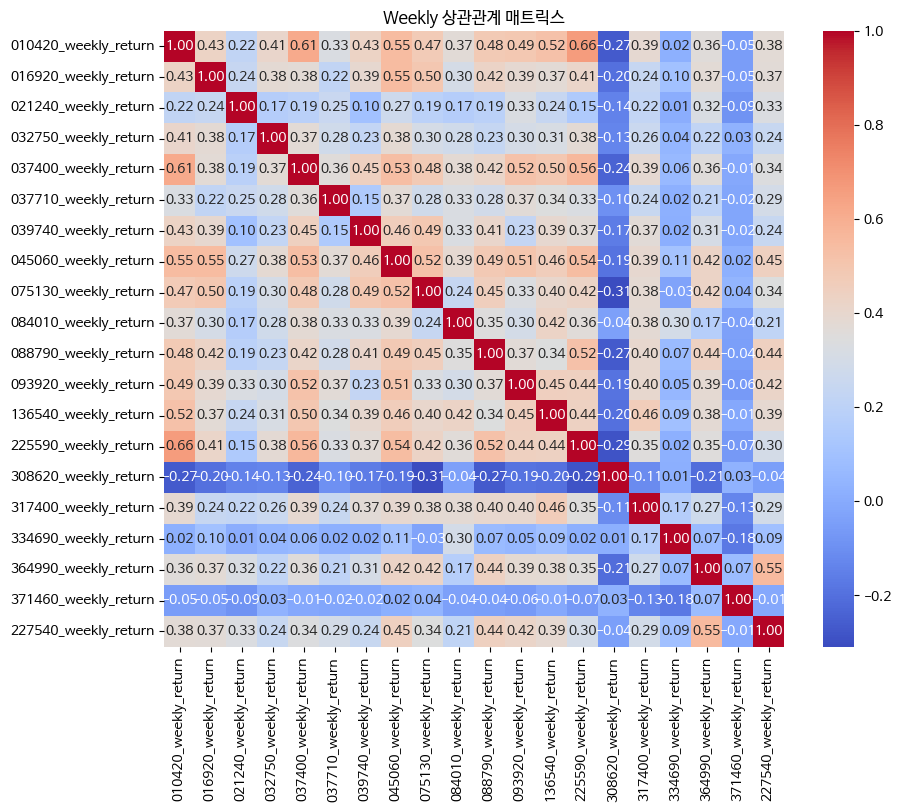

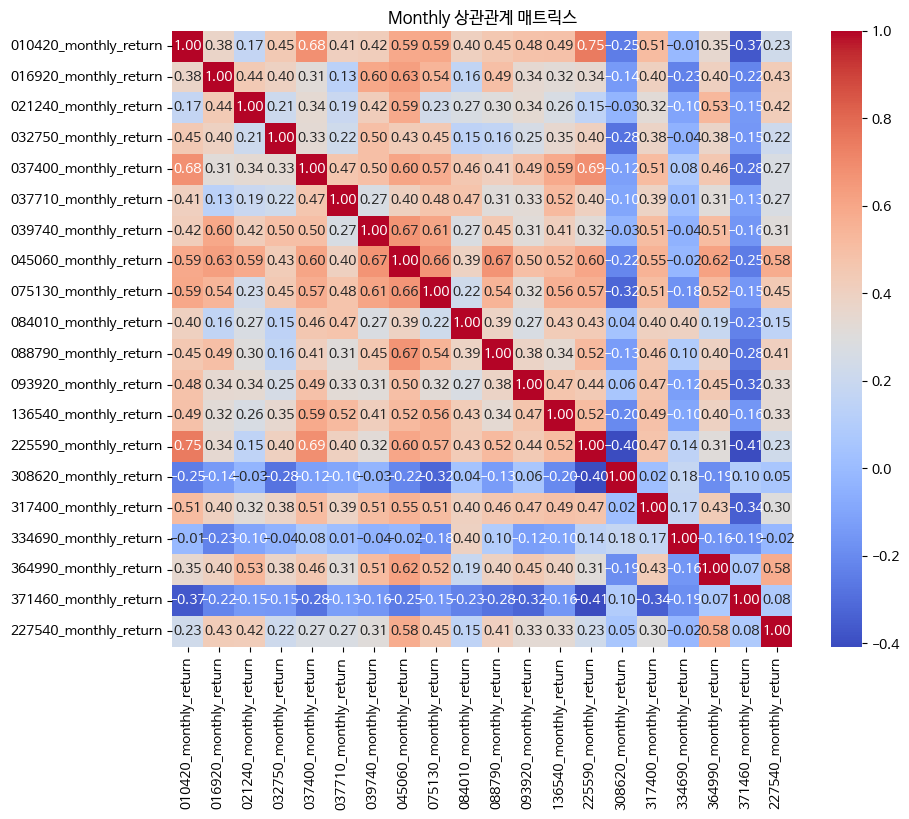

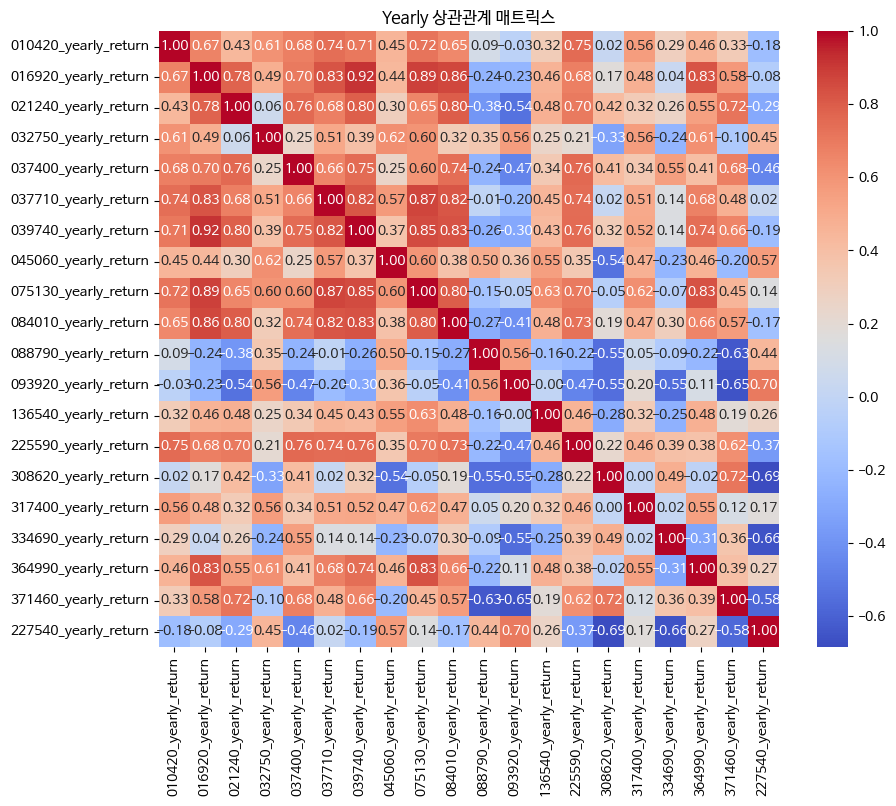

상관관계 매트릭스 내용 확인


In [35]:


# 다양한 기간에 대한 상관관계 매트릭스를 계산
timeframes = ['daily', 'weekly', 'monthly', 'yearly']
correlation_matrices = {timeframe: returns.filter(regex=f'_{timeframe}_').corr() for timeframe in ['daily', 'weekly', 'monthly', 'yearly']}


# 상관관계 매트릭스를 시각화
for timeframe, matrix in correlation_matrices.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'{timeframe.capitalize()} 상관관계 매트릭스')
    plt.show()


# 상관관계 매트릭스 내용 확인
print("상관관계 매트릭스 내용 확인")
timeframes = ['daily', 'weekly', 'monthly', 'yearly']
correlation_matrices = {timeframe: returns.filter(regex=f'_{timeframe}_return').corr() for timeframe in timeframes}

In [36]:
# 각 주식이 다른 모든 주식과의 평균 상관관계를 계산
stock_average_correlations = {timeframe: {} for timeframe in timeframes}

for timeframe, matrix in correlation_matrices.items():
    # 열 이름에서 주식 코드를 추출
    stock_codes_in_matrix = matrix.columns.str.extract(r'(\d+)')[0]
    matrix.columns = stock_codes_in_matrix  # 열 이름을 주식 코드로 변경
    matrix.index = stock_codes_in_matrix  # 인덱스를 주식 코드로 변경
    for stock_code in stock_codes:
        if stock_code in matrix.columns:
            # 해당 주식이 다른 모든 주식과의 상관관계
            stock_correlations = matrix[stock_code]
            # 자신의 상관관계를 제외한 평균 상관관계 계산
            stock_average_correlations[timeframe][stock_code] = stock_correlations.drop(labels=[stock_code]).mean()

# 평균 상관관계 테이블 생성 및 출력
average_correlations_table = pd.DataFrame(stock_average_correlations).T
average_correlations_table = average_correlations_table.round(3)

print("평균 상관관계 테이블:")
print(average_correlations_table)

# 테이블을 CSV 파일로 저장 (선택 사항)
# average_correlations_table.to_csv('average_correlations.csv')

평균 상관관계 테이블:
         010420  016920  021240  032750  037400  037710  039740  045060  \
daily     0.312   0.265   0.175   0.213   0.252   0.202   0.254   0.283   
weekly    0.358   0.306   0.177   0.246   0.349   0.239   0.272   0.380   
monthly   0.354   0.302   0.259   0.253   0.387   0.282   0.361   0.448   
yearly    0.435   0.488   0.394   0.326   0.406   0.491   0.486   0.330   

         075130  084010  088790  093920  136540  225590  308620  317400  \
daily     0.255   0.218   0.256   0.280   0.281   0.297  -0.170   0.235   
weekly    0.313   0.273   0.315   0.317   0.332   0.329  -0.161   0.282   
monthly   0.378   0.277   0.335   0.304   0.344   0.340  -0.104   0.365   
yearly    0.507   0.460  -0.076  -0.103   0.284   0.414  -0.002   0.356   

         334690  364990  371460  227540  
daily     0.071   0.261   0.042   0.267  
weekly    0.054   0.287  -0.031   0.296  
monthly  -0.007   0.345  -0.186   0.296  
yearly    0.031   0.413   0.247  -0.033  


# 종목의 표준편차 계산

In [38]:
# 문자열을 실수로 변환하는 함수
import math
def convert_to_float(x):
    try:
        return float(x.replace(',', ''))  # 콤마 제거 후 실수로 변환
    except:
        return x

# '종가', '시가' 열의 값들을 실수로 변환합니다.
df['종가'] = df['종가'].apply(convert_to_float)
df['시가'] = df['시가'].apply(convert_to_float)

# 일별 수익률을 계산합니다. (당일 종가 / 당일 시가 - 1)
df['수익률'] = df['종가'] / df['시가'] - 1

# 수익률의 표준편차를 계산합니다.
std_dev = df['수익률'].std()

# 연간 표준편차 계산
annual_std_dev = std_dev * math.sqrt(12)


print(std_dev)

print(annual_std_dev)

0.01633126831188192
0.05657317293643818


In [40]:
# 연환산 수익률을 계산하는 함수
def calculate_annualized_return(df):
    initial_price = df.iloc[-1]['종가']
    current_price = df.iloc[0]['종가']
    start_date = pd.to_datetime(df.index[-1])
    end_date = pd.to_datetime(df.index[0])
    duration_years = (end_date - start_date).days / 365.25
    total_return = (current_price / initial_price) - 1
    annualized_return = ((1 + total_return)**(1/duration_years)) - 1
    return annualized_return


# 예시: 단일 주식 데이터에 대해 연환산 수익률 계산
if 'df' in locals():
    annualized_return = calculate_annualized_return(df)
    print(f"2001년 01월부터 현재까지의 연환산 수익률: {annualized_return * 100:.2f}%")







2001년 01월부터 현재까지의 연환산 수익률: -2.77%


In [41]:
# 모든 주식 티커를 수집하는 함수
def collect_all_tickers(start_year=1990):
    current_year = datetime.datetime.now().year
    all_tickers = set()
    for year in range(start_year, current_year + 1):
        date_str = f"{year}1231"
        tickers_kosdaq = stock.get_market_ticker_list(date_str, market='KOSDAQ')
        tickers_kospi = stock.get_market_ticker_list(date_str, market='KOSPI')
        all_tickers.update(tickers_kosdaq)
        all_tickers.update(tickers_kospi)
        time.sleep(1)
    return all_tickers

# 티커 수집
all_tickers = collect_all_tickers()
print(f"수집된 총 티커 수: {len(all_tickers)}")

수집된 총 티커 수: 4900
